# inspect diffusion model

## ! this contains internal data and projects/ wont run

In [1]:
!conda info | grep enviro

     active environment : abj
       base environment : /home/z/miniconda3  (writable)


In [2]:
import matplotlib.pyplot as plt
import torch
from denoising_diffusion_pytorch.denoising_diffusion_pytorch import *
from augment.transforms import Show, NormToRange

N = NormToRange()
S = Show()

vision/training/tensorboard.py suppresses FutureWarning: change from tensorboard==1.14 to nightly or 2.0


In [3]:
path = "/home/z/data/Self/Multitudes"
self_ds = Dataset(path, 128)
train_batch_size =32
self_dl = cycle(data.DataLoader(self_ds, batch_size = train_batch_size, shuffle=True, pin_memory=True))


In [4]:
model = Unet(dim = 64, dim_mults = (1, 2, 4, 8))

self = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000,   # number of steps
    loss_type = 'l1'    # L1 or L2
)

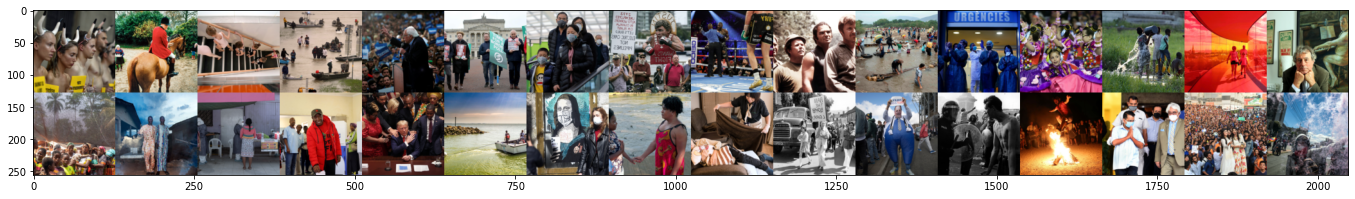

In [5]:
x = next(self_dl)
S(N(x), ncols=16)

GaussianDiffusion().forward(x, *args, **kwargs) ->
  timesteps 1000
  t: tensor([994, 700, 446, 257, 631, 982, 683, 363, 675, 601, 563, 205, 484, 822,
        245,  61,  93, 907, 943, 594, 952, 320, 870, 862,  21, 401, 749, 998,
        373, 897, 929, 897])

  GaussianDiffusion().p_losses(x, t, *args, **kwargs) ->
    noise torch.Size([32, 3, 128, 128]), [-4.980 4.675]


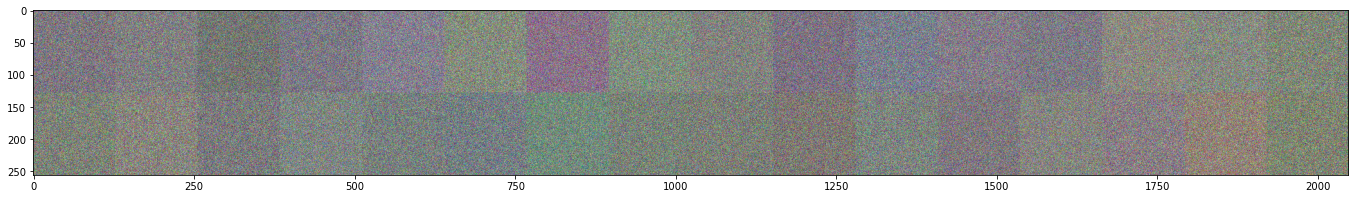

    GaussianDiffusion().q_sample(x,t) -> torch.Size([32, 3, 128, 128])


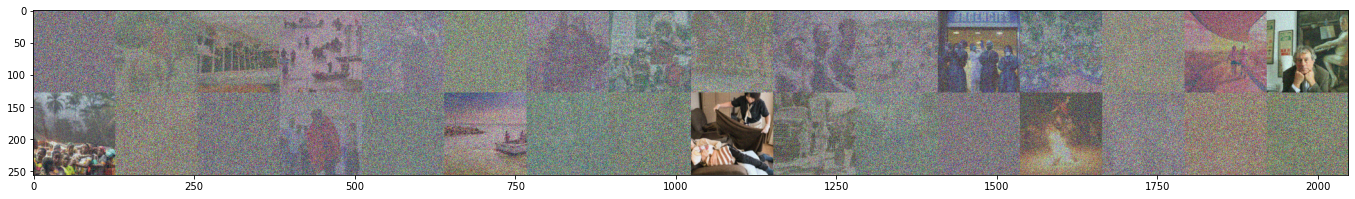

In [6]:
# GaussianDiffusion().forward(x, *args, **kwargs)
print("GaussianDiffusion().forward(x, *args, **kwargs) ->")
b, c, h, w, device, img_size, = *x.shape, x.device, self.image_size
t = torch.randint(0, self.num_timesteps, (b,), device=device).long()
print(f"  timesteps {self.num_timesteps}\n  t: {t}")

# GaussianDiffusion().p_losses(self, x_start, t, noise = None):
print('\n  GaussianDiffusion().p_losses(x, t, *args, **kwargs) ->')
noise = None
noise = default(noise, lambda: torch.randn_like(x))
print(f'    noise {noise.shape}, [{noise.min().item():.3f} {noise.max().item():.3f}]')
S(N(noise), ncols=16)

x_noisy = self.q_sample(x_start=x, t=t, noise=noise)
print(f"    GaussianDiffusion().q_sample(x,t) -> {x_noisy.shape}")
S(N(x_noisy), ncols=16)


q_sample is not exactly a lerp


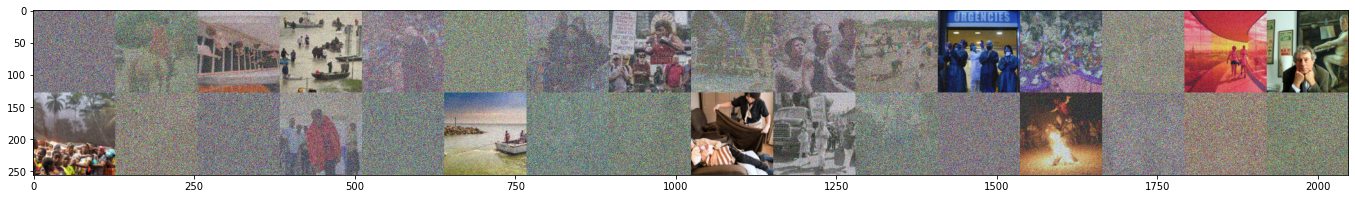

but x*sqrt(cumprod[t] + noise*sqrt(1-cumprod[t]))


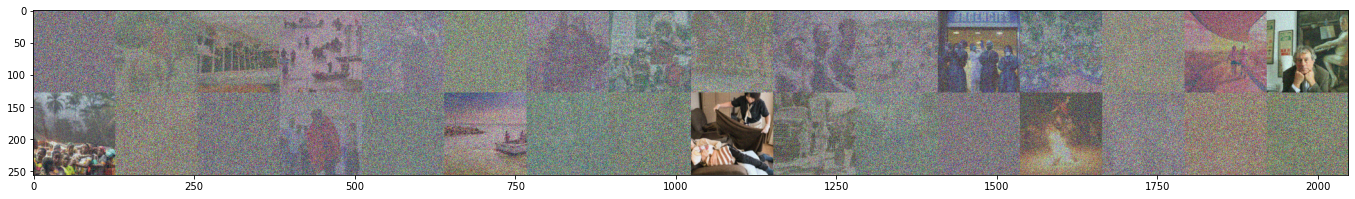

In [7]:
print("q_sample is not exactly a lerp")
S(N(torch.lerp(noise,x, self.sqrt_alphas_cumprod[t].view(len(x),1,1,1))), ncols=16)
print("but x*sqrt(cumprod[t] + noise*sqrt(1-cumprod[t]))")
q_sample = self.sqrt_alphas_cumprod[t].view(len(x), 1,1,1)*x + self.sqrt_one_minus_alphas_cumprod[t].view(len(x),1,1,1)*noise
S(N(q_sample), ncols=16)

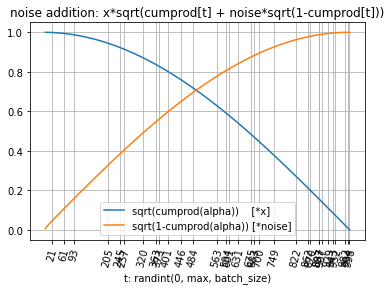

In [8]:
plt.title("noise addition: x*sqrt(cumprod[t] + noise*sqrt(1-cumprod[t]))")
plt.plot(self.sqrt_alphas_cumprod.clone().detach(), label="sqrt(cumprod(alpha))    [*x]")
plt.plot(self.sqrt_one_minus_alphas_cumprod.clone().detach(), label="sqrt(1-cumprod(alpha)) [*noise]")
plt.grid()
plt.legend()
plt.xticks(t, rotation=75)
plt.xlabel("t: randint(0, max, batch_size)")
plt.show()

In [9]:
# denoise_fn: UNet
x_recon = self.denoise_fn(x_noisy, t)

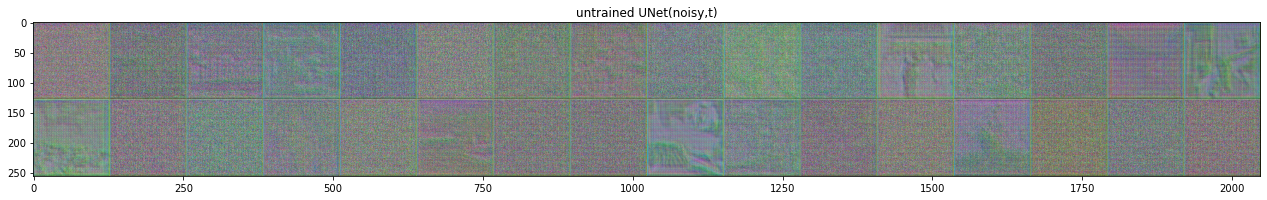

In [10]:
S(N(x_recon.clone().detach()), ncols=16, title="untrained UNet(noisy,t)")

In [11]:
loss = (noise - x_recon).abs().mean()
print(loss.clone().detach())

tensor(0.8059)


## The U Net

In [12]:
self.denoise_fn.time_mlp

Sequential(
  (0): SinusoidalPosEmb()
  (1): Linear(in_features=64, out_features=256, bias=True)
  (2): GELU()
  (3): Linear(in_features=256, out_features=64, bias=True)
)

In [13]:
dim = 64
dim_mults = (1, 2, 4, 8)
channels = self.denoise_fn.channels
dims = [channels, *map(lambda m: dim * m, dim_mults)]
in_out = list(zip(dims[:-1], dims[1:]))
dims, in_out

([3, 64, 128, 256, 512], [(3, 64), (64, 128), (128, 256), (256, 512)])

## Position Embedding

differneces with Attention is All You Need:

    * does not alternate sin and cosine, does not create a table
    * porcesses every set of samples and passes through 2 linear layers

In [14]:
from torch import nn
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [17]:
PosEmb = SinusoidalPosEmb(64) #64 dimensions to t
pe = PosEmb(t)

In [18]:
half_dim = PosEmb.dim // 2
emb = math.log(10000) / (half_dim - 1)
emb

0.2971077539347156

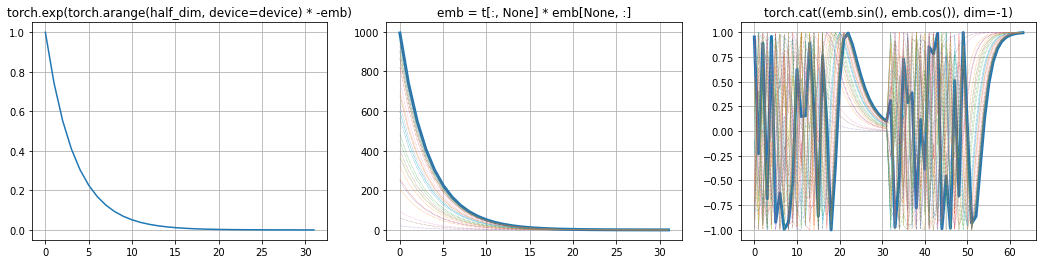

In [19]:
emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
plt.figure(figsize=(18,4))
plt.subplot(131)
plt.title("torch.exp(torch.arange(half_dim, device=device) * -emb)")

plt.plot(emb)
plt.grid()
plt.subplot(132)

emb = t[:, None] * emb[None, :]
plt.title("emb = t[:, None] * emb[None, :]")
for i, m in enumerate(emb):
    kw = {'linewidth':0.5 if i else 3, 'linestyle':":" if i else "-"}
    plt.plot(m, **kw)
plt.grid()
plt.subplot(133)
plt.title("torch.cat((emb.sin(), emb.cos()), dim=-1)")

emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
for i, m in enumerate(emb):
    kw = {'linewidth':0.5 if i else 3, 'linestyle':":" if i else "-"}
    plt.plot(m, **kw)
plt.grid()
plt.show()

In [20]:
emb.shape, PosEmb.dim

(torch.Size([32, 64]), 64)

In [21]:
[p.numel() for p in PosEmb.parameters()], PosEmb.dim

([], 64)

In [22]:
t.shape, pe.shape

(torch.Size([32]), torch.Size([32, 64]))

In [23]:
print("denoise_fn: UNet().forward(x, t)")
print(f" input t {t}")
print(f" SinusoidalPosEmb(t) {self.denoise_fn.time_mlp(t).clone().detach().shape}")

denoise_fn: UNet().forward(x, t)
 input t tensor([994, 700, 446, 257, 631, 982, 683, 363, 675, 601, 563, 205, 484, 822,
        245,  61,  93, 907, 943, 594, 952, 320, 870, 862,  21, 401, 749, 998,
        373, 897, 929, 897])
 SinusoidalPosEmb(t) torch.Size([32, 64])


In [25]:
# ConvNextBlock(dim_in, dim_out, time_emb_dim = time_dim, norm = ind != 0)

In [26]:
self.denoise_fn

Unet(
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU()
    (3): Linear(in_features=256, out_features=64, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ConvNextBlock(
        (mlp): Sequential(
          (0): GELU()
          (1): Linear(in_features=64, out_features=3, bias=True)
        )
        (ds_conv): Conv2d(3, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=3)
        (net): Sequential(
          (0): Identity()
          (1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): GELU()
          (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (res_conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): ConvNextBlock(
        (mlp): Sequential(
          (0): GELU()
          (1): Linear(in_features=64, out_features=64, bias=True)
        )
        (ds_conv): Conv2d(64, 64, k

In [27]:
i=0
for convnext, convnext2, attn, downsample in self.denoise_fn.downs:
    print(i, "convnext, convnext2, attn, downsample")
    print(f" convnext {tuple(convnext.res_conv.weight.shape[:2])}")
    print(f" convnext2 {tuple(convnext2.ds_conv.weight.shape)[0]}")
    if hasattr(downsample, "weight"):
        print(f" downsample {tuple(downsample.weight.shape)}")
    i += 1

0 convnext, convnext2, attn, downsample
 convnext (64, 3)
 convnext2 64
 downsample (64, 64, 4, 4)
1 convnext, convnext2, attn, downsample
 convnext (128, 64)
 convnext2 128
 downsample (128, 128, 4, 4)
2 convnext, convnext2, attn, downsample
 convnext (256, 128)
 convnext2 256
 downsample (256, 256, 4, 4)
3 convnext, convnext2, attn, downsample
 convnext (512, 256)
 convnext2 512


## inference steps. after a few hours training

In [28]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import os.path as osp


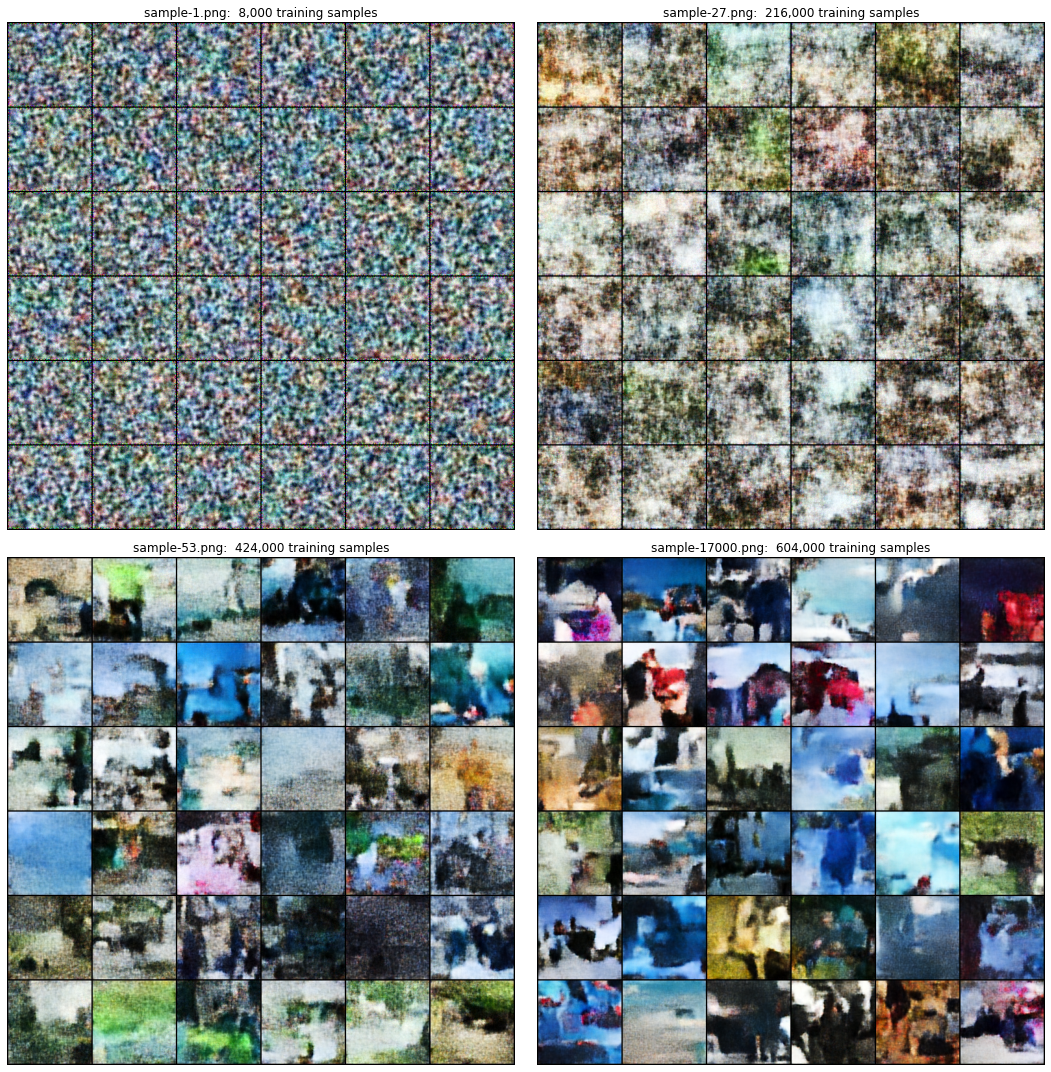

In [29]:
# trained for 53 * 250 iterations of 32 sized batches
# continued for 1000 iteration 48 sized batches 

inf = sorted([f.path for f in os.scandir("results_multitudes")
              if f.name[-4:] ==".png"],
              key=lambda x: int(x.split(".")[0].split("-")[1]))
save_every=250
batch_size=32

plt.figure(figsize=(15,15))
plt.subplot(221)
i = 0
samples = (i+1)*32*250
plt.title(f"{osp.basename(inf[0])}:  {samples:,} training samples")
plt.imshow(Image.open(inf[0]))
plt.axis("off")

plt.subplot(222)
i=26
samples = 32*(i+1)*250
plt.title(f"{osp.basename(inf[i])}:  {samples:,} training samples")
plt.imshow(Image.open(inf[i]))
plt.axis("off")

plt.subplot(223)
i=52
samples = 32*(i+1)*250
plt.title(f"{osp.basename(inf[i])}:  {samples:,} training samples")
plt.imshow(Image.open(inf[i]))
plt.axis("off")

save_every=1000
batch_size=48

plt.subplot(224)
samples = lambda x: (x - 53*250)*48 + 53*250*32
iteration = int(inf[-1].split(".")[0].split("-")[1])
plt.title(f"{osp.basename(inf[-1])}:  {samples(iteration):,} training samples")
plt.imshow(Image.open(inf[-1]))
plt.axis("off")
plt.tight_layout()
plt.show()

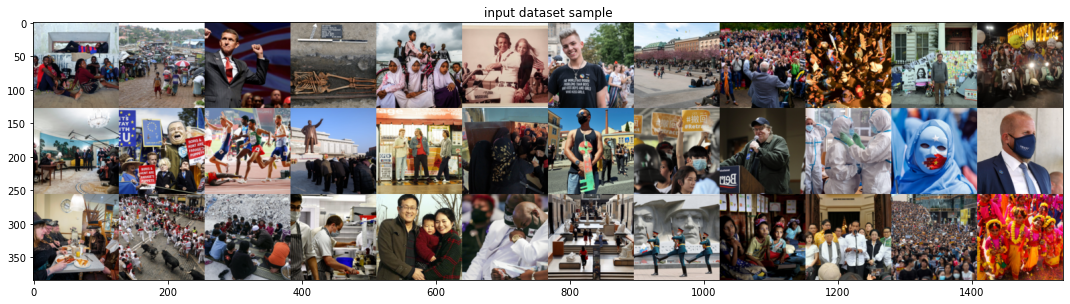

In [33]:
train_batch_size =36
self_dl = cycle(data.DataLoader(self_ds, batch_size = train_batch_size, shuffle=True, pin_memory=True))
x = next(self_dl)
S(N(x), ncols=12, title="input dataset sample", width=15)